<a href="https://colab.research.google.com/github/FilatovArtem/MTS_ML-Course/blob/main/HW_AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUPED EXPERIMENT

1. Data correlation check...
   Pre-post correlation: 0.715

2. Type I error test...
Testing Type I error (A/A)...
  0/1000
  200/1000
  400/1000
  600/1000
  800/1000
   {'classic': np.float64(0.062), 'cuped_ctrl': np.float64(0.052), 'cuped_treat': np.float64(0.049), 'multi': np.float64(0.053)}

3. Power test...
Testing power for different effect sizes...
  effect=0.05
    0/500
    100/500
    200/500
    300/500
    400/500
  effect=0.1
    0/500
    100/500
    200/500
    300/500
    400/500
  effect=0.15
    0/500
    100/500
    200/500
    300/500
    400/500
  effect=0.2
    0/500
    100/500
    200/500
    300/500
    400/500
  effect=0.25
    0/500
    100/500
    200/500
    300/500
    400/500

4. Plotting...


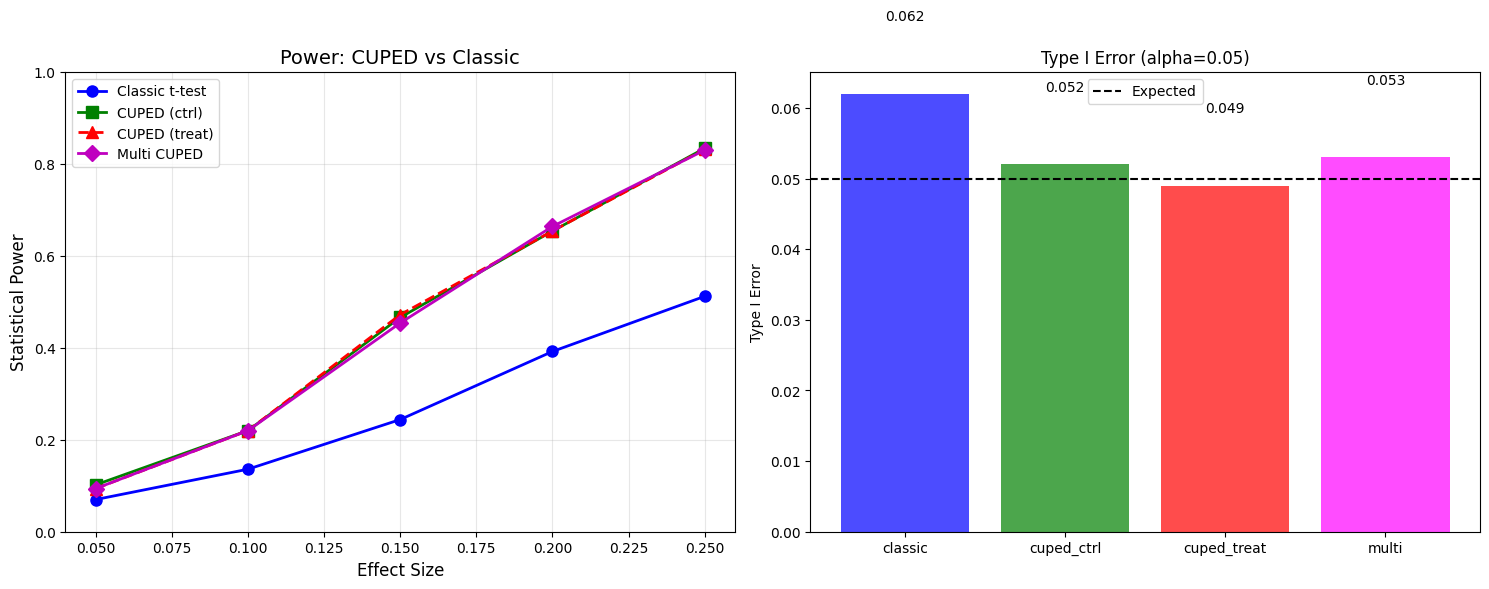


Power Comparison
Effect     Classic    CUPED(C)   CUPED(T)   Multi     
----------------------------------------------------------------------
0.05       0.070      0.102      0.094      0.094     
0.10       0.136      0.220      0.220      0.220     
0.15       0.244      0.466      0.472      0.454     
0.20       0.392      0.654      0.654      0.664     
0.25       0.512      0.834      0.832      0.830     

5. Treatment bias analysis...

Treatment group bias demo
  0/1000
  200/1000
  400/1000
  600/1000
  800/1000

Mean theta bias: -0.0012 ± 0.0431
Type I (ctrl): 0.0280
Type I (treat): 0.0310
Relative bias: 38.0%


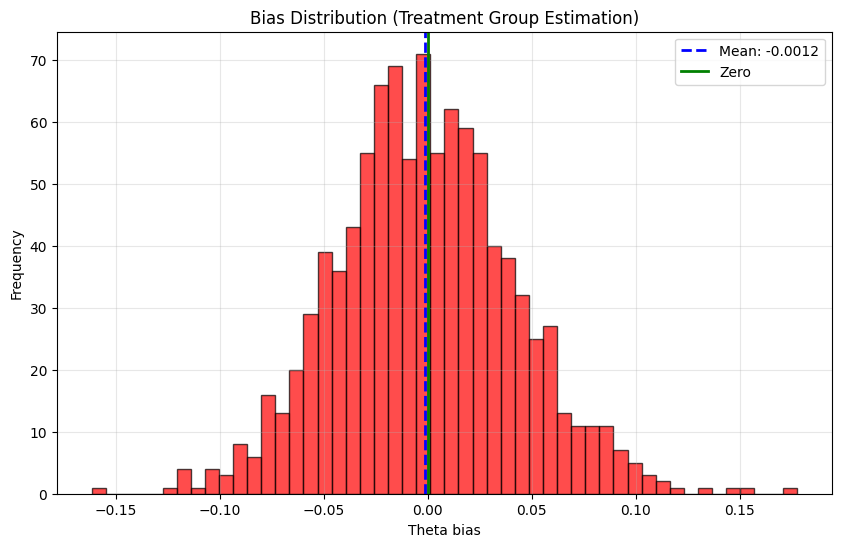


6. Correlation impact...

Correlation impact on CUPED
  corr=0.1
    0/300
    100/300
    200/300
  corr=0.3
    0/300
    100/300
    200/300
  corr=0.5
    0/300
    100/300
    200/300
  corr=0.7
    0/300
    100/300
    200/300
  corr=0.9
    0/300
    100/300
    200/300


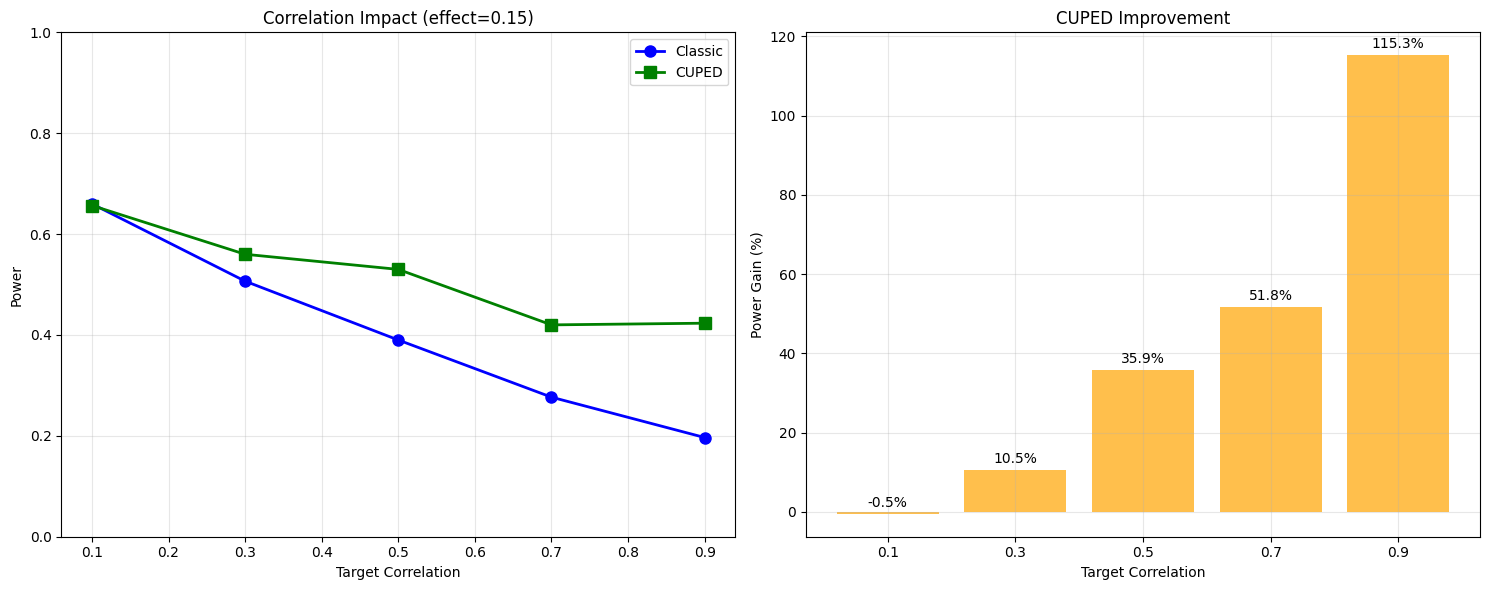


Results:
Target     Actual     Classic    CUPED      Gain      
-------------------------------------------------------
0.1        0.037      0.660      0.657      -0.5      %
0.3        0.265      0.507      0.560      10.5      %
0.5        0.498      0.390      0.530      35.9      %
0.7        0.662      0.277      0.420      51.8      %
0.9        0.764      0.197      0.423      115.3     %

DONE


In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


def generate_data(n=1000, effect=0.0, corr=0.7, noise=1.0):
    user_char = np.random.normal(0, 2, n)
    pre = user_char * corr + np.random.normal(0, noise, n)
    treatment = np.random.binomial(1, 0.5, n)
    post = user_char * corr + treatment * effect + np.random.normal(0, noise, n)
    return pre, post, treatment


def ttest(pre, post, treatment):
    ctrl, treat = post[treatment == 0], post[treatment == 1]
    return st.ttest_ind(treat, ctrl, equal_var=False).pvalue


def cuped(pre, post, treatment, use_ctrl=True):
    mask = (treatment == 0) if use_ctrl else (treatment == 1)

    if np.sum(mask) > 10 and np.var(pre[mask]) > 1e-10:
        theta = np.cov(pre[mask], post[mask])[0, 1] / np.var(pre[mask])
    else:
        theta = 0

    adj = post - theta * (pre - pre.mean())
    ctrl, treat = adj[treatment == 0], adj[treatment == 1]
    return st.ttest_ind(treat, ctrl, equal_var=False).pvalue


def multi_cuped(pre, covariates, post, treatment):
    X = np.column_stack([pre] + covariates)
    X = StandardScaler().fit_transform(X)

    mask = treatment == 0
    if len(X[mask]) <= X.shape[1] + 1:
        return ttest(pre, post, treatment)

    model = LinearRegression().fit(X[mask], post[mask])
    pred = model.predict(X)
    adj = post - pred + post[mask].mean()

    ctrl, treat = adj[treatment == 0], adj[treatment == 1]
    return st.ttest_ind(treat, ctrl, equal_var=False).pvalue


def test_type1(n_sim=1000, n=1000, corr=0.8):
    print("Testing Type I error (A/A)...")

    results = {k: [] for k in ['classic', 'cuped_ctrl', 'cuped_treat', 'multi']}

    for i in range(n_sim):
        if i % 200 == 0:
            print(f"  {i}/{n_sim}")

        pre, post, treat = generate_data(n, 0.0, corr)
        covs = [np.random.normal(0, 1, n) + pre * c for c in [0.5, 0.3]]

        results['classic'].append(ttest(pre, post, treat))
        results['cuped_ctrl'].append(cuped(pre, post, treat, True))
        results['cuped_treat'].append(cuped(pre, post, treat, False))
        results['multi'].append(multi_cuped(pre, covs, post, treat))

    errors = {k: (np.array(v) < 0.05).mean() for k, v in results.items()}
    return errors, results


def test_power(n_sim=500, n=1000, corr=0.8):
    print("Testing power for different effect sizes...")

    effects = [0.05, 0.1, 0.15, 0.2, 0.25]
    results = {}

    for eff in effects:
        print(f"  effect={eff}")
        power = {k: [] for k in ['classic', 'cuped_ctrl', 'cuped_treat', 'multi']}

        for i in range(n_sim):
            if i % 100 == 0:
                print(f"    {i}/{n_sim}")

            pre, post, treat = generate_data(n, eff, corr)
            covs = [np.random.normal(0, 1, n) + pre * c for c in [0.5, 0.3]]

            power['classic'].append(ttest(pre, post, treat) < 0.05)
            power['cuped_ctrl'].append(cuped(pre, post, treat, True) < 0.05)
            power['cuped_treat'].append(cuped(pre, post, treat, False) < 0.05)
            power['multi'].append(multi_cuped(pre, covs, post, treat) < 0.05)

        results[eff] = {k: np.mean(v) for k, v in power.items()}

    return results


def plot_results(power_res, type1=None):
    effects = list(power_res.keys())
    methods = ['classic', 'cuped_ctrl', 'cuped_treat', 'multi']
    labels = ['Classic t-test', 'CUPED (ctrl)', 'CUPED (treat)', 'Multi CUPED']
    styles = ['b-o', 'g-s', 'r--^', 'm-D']

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Power plot
    for method, label, style in zip(methods, labels, styles):
        power = [power_res[e][method] for e in effects]
        axes[0].plot(effects, power, style, label=label, linewidth=2, markersize=8)

    axes[0].set_xlabel('Effect Size', fontsize=12)
    axes[0].set_ylabel('Statistical Power', fontsize=12)
    axes[0].set_title('Power: CUPED vs Classic', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1)

    # Type I error plot
    if type1:
        colors = ['blue', 'green', 'red', 'magenta']
        keys = list(type1.keys())
        vals = [type1[k] for k in keys]

        bars = axes[1].bar(keys, vals, color=colors, alpha=0.7)
        axes[1].axhline(0.05, color='black', linestyle='--', label='Expected')
        axes[1].set_ylabel('Type I Error')
        axes[1].set_title('Type I Error (alpha=0.05)')
        axes[1].legend()

        for bar, val in zip(bars, vals):
            axes[1].text(bar.get_x() + bar.get_width()/2,
                        bar.get_height() + 0.01, f'{val:.3f}',
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print table
    print("\n" + "="*70)
    print("Power Comparison")
    print("="*70)
    print(f"{'Effect':<10} {'Classic':<10} {'CUPED(C)':<10} {'CUPED(T)':<10} {'Multi':<10}")
    print("-"*70)
    for e in effects:
        print(f"{e:<10.2f} {power_res[e]['classic']:<10.3f} "
              f"{power_res[e]['cuped_ctrl']:<10.3f} "
              f"{power_res[e]['cuped_treat']:<10.3f} "
              f"{power_res[e]['multi']:<10.3f}")


def show_treatment_bias(n_sim=1000):
    print("\n" + "="*60)
    print("Treatment group bias demo")
    print("="*60)

    biases, err_ctrl, err_treat = [], [], []

    for i in range(n_sim):
        if i % 200 == 0:
            print(f"  {i}/{n_sim}")

        pre, post, treat = generate_data(1000, 0.0, 0.8)

        ctrl_mask = treat == 0
        treat_mask = treat == 1

        if (ctrl_mask.sum() > 10 and pre[ctrl_mask].var() > 1e-10 and
            treat_mask.sum() > 10 and pre[treat_mask].var() > 1e-10):

            theta_c = np.cov(pre[ctrl_mask], post[ctrl_mask])[0,1] / pre[ctrl_mask].var()
            theta_t = np.cov(pre[treat_mask], post[treat_mask])[0,1] / pre[treat_mask].var()
            biases.append(theta_t - theta_c)

            err_ctrl.append(cuped(pre, post, treat, True) < 0.05)
            err_treat.append(cuped(pre, post, treat, False) < 0.05)

    mean_bias = np.mean(biases)
    std_bias = np.std(biases)

    print(f"\nMean theta bias: {mean_bias:.4f} ± {std_bias:.4f}")
    print(f"Type I (ctrl): {np.mean(err_ctrl):.4f}")
    print(f"Type I (treat): {np.mean(err_treat):.4f}")
    print(f"Relative bias: {abs(np.mean(err_treat) - 0.05)/0.05*100:.1f}%")

    plt.figure(figsize=(10, 6))
    plt.hist(biases, bins=50, alpha=0.7, color='red', edgecolor='black')
    plt.axvline(mean_bias, color='blue', linestyle='--', linewidth=2,
                label=f'Mean: {mean_bias:.4f}')
    plt.axvline(0, color='green', linestyle='-', linewidth=2, label='Zero')
    plt.xlabel('Theta bias')
    plt.ylabel('Frequency')
    plt.title('Bias Distribution (Treatment Group Estimation)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return mean_bias, np.mean(err_ctrl), np.mean(err_treat)


def analyze_correlation(n_sim=300):
    print("\n" + "="*60)
    print("Correlation impact on CUPED")
    print("="*60)

    corrs = [0.1, 0.3, 0.5, 0.7, 0.9]
    results = []

    for c in corrs:
        print(f"  corr={c}")
        classic_pow, cuped_pow, actual_corrs = [], [], []

        for i in range(n_sim):
            if i % 100 == 0:
                print(f"    {i}/{n_sim}")

            pre, post, treat = generate_data(1000, 0.15, c)
            actual_corrs.append(np.corrcoef(pre, post)[0,1])

            classic_pow.append(ttest(pre, post, treat) < 0.05)
            cuped_pow.append(cuped(pre, post, treat, True) < 0.05)

        classic_m = np.mean(classic_pow)
        cuped_m = np.mean(cuped_pow)

        results.append({
            'target': c,
            'actual': np.mean(actual_corrs),
            'classic': classic_m,
            'cuped': cuped_m,
            'gain': (cuped_m - classic_m) / classic_m * 100
        })

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    targets = [r['target'] for r in results]
    classics = [r['classic'] for r in results]
    cupeds = [r['cuped'] for r in results]
    gains = [r['gain'] for r in results]

    ax1.plot(targets, classics, 'b-o', label='Classic', linewidth=2, markersize=8)
    ax1.plot(targets, cupeds, 'g-s', label='CUPED', linewidth=2, markersize=8)
    ax1.set_xlabel('Target Correlation')
    ax1.set_ylabel('Power')
    ax1.set_title('Correlation Impact (effect=0.15)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    ax2.bar([str(t) for t in targets], gains, color='orange', alpha=0.7)
    ax2.set_xlabel('Target Correlation')
    ax2.set_ylabel('Power Gain (%)')
    ax2.set_title('CUPED Improvement')
    ax2.grid(True, alpha=0.3)

    for i, v in enumerate(gains):
        ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("\nResults:")
    print(f"{'Target':<10} {'Actual':<10} {'Classic':<10} {'CUPED':<10} {'Gain':<10}")
    print("-"*55)
    for r in results:
        print(f"{r['target']:<10.1f} {r['actual']:<10.3f} {r['classic']:<10.3f} "
              f"{r['cuped']:<10.3f} {r['gain']:<10.1f}%")

    return results


def run_experiment():
    print("="*70)
    print("CUPED EXPERIMENT")
    print("="*70)

    # Quick data check
    print("\n1. Data correlation check...")
    pre, post, treat = generate_data(1000, 0.0, 0.8)
    print(f"   Pre-post correlation: {np.corrcoef(pre, post)[0,1]:.3f}")

    # Type I error
    print("\n2. Type I error test...")
    type1, _ = test_type1(1000, 1000, 0.8)
    print(f"   {type1}")

    # Power
    print("\n3. Power test...")
    power = test_power(500, 1000, 0.8)

    # Visualize
    print("\n4. Plotting...")
    plot_results(power, type1)

    # Bias demo
    print("\n5. Treatment bias analysis...")
    bias_res = show_treatment_bias(1000)

    # Correlation impact
    print("\n6. Correlation impact...")
    corr_res = analyze_correlation(300)

    print("\n" + "="*70)
    print("DONE")
    print("="*70)


if __name__ == "__main__":
    run_experiment()